In [1]:
import numpy as np
import torch
from problems import *
from matplotlib import pyplot as plt
from copy import deepcopy
import pandas as pd

# Calculus of variations with NN (pytorch)

## 1. Problem statement

Пусть стоит задача
$$\begin{cases}
\displaystyle \int\limits_{t_0}^{t_f} f\big(t, x(t), \dot{x}(t)\big) dt \longrightarrow \min_{x(t)} \\
\displaystyle x(t_0) = x_0, \ \ \ x(t_f) = x_f
\end{cases}$$

Пусть для примера
$$f(t,x,\dot{x}) = x^2 + t\dot{x} + \dot{x}^2, \ \ \ \ x(0) = 0, \ \ x(1) = 0.25$$

## 2. Building the loss function

### 2.1 Main functional loss

$$\widehat{J}_0(x) = \sum_{k=0}^{N-1} f \big(t_k, x_k, \dot{x}_k(x)\big) \cdot h \longrightarrow \min_{x_1, \ldots, x_{N-1}}$$

Если точки $x_i$ вычисляются косвенно, то есть $x = x(\theta),$ где $\theta$ - еще какие-то параметры, то $\widehat{J}_0 = \widehat{J}_0(\theta)$.

In [2]:
def rectangle_left_rule(t, x, xp, f):
    # t = (t_0, ..., t_N) - torch.tensor,
    # x = (x_0,..., x_N) - torch.tensor
    # xp = (xp_0, ..., xp_N) - torch.tensor
    # f - given function
    
    h = t[1] - t[0] # time step    
    return torch.sum(f(t[:-1], x[:-1], xp[:-1])) * h

def trapezoidal_rule(t, x, xp, f):
    h = t[1] - t[0] # time step
    return torch.sum(f(t[:-1], x[:-1], xp[:-1]) + f(t[1:], x[1:], xp[1:])) * h / 2

def simpsons_rule(t, x, xp, f):
    h = t[1] - t[0] # time step
    return (2*torch.sum(f(t[::2], x[::2], xp[::2])) + 4*torch.sum(f(t[1::2], x[1::2], xp[1::2])) - f(t[0], x[0], xp[0]) - f(t[-1], x[-1], xp[-1])) * h / 3


### 2.2 Known points loss

Если мы знаем, через какие точки $(t_j^\ast, x_j^\ast)$ должно проходить решение, то можно сделать добавку

$$\widehat{J}_{\text{points}}(\theta) = \sum_{j=1}^m \big\lvert \ x(t_j^\ast, \theta) - x_j^\ast \big\rvert^2$$

In [3]:
def J_points(x, x_star):
    # x_star = (x*_1, ..., x*_m) - known values at points t*_1, ..., t*_m - torch.tensor
    # x = (x_1, ..., x_m) - predictions at points t*_1, ..., t*_m - torch.tensor
    
    return torch.sum((x - x_star) * (x - x_star))

### 2.3 Total loss

$$\widehat{J}(\theta) = \widehat{J}_0(x(\theta)) + \lambda_p \widehat{J}_p(\theta) + \lambda_1 \lVert \theta \rVert_1 + \lambda_2 \lVert \theta \rVert^2_2$$

## 3. Model construction

In [4]:
def simple_transform(t, x, t_0, t_f, x_0, x_f):
    # t, x - torch.tensor's
    # t_0, t_f, x_0, x_f - scalars
    return x_0 + (x_f - x_0) / (t_f - t_0) * (t - t_0) + (t - t_0) * (t - t_f) * x

def identity_transform(t, x, t_0, t_f, x_0, x_f):
    return x

In [5]:
class CosineLayer(torch.nn.Module):
    def forward(self, x):
        n_basis = x.size()[1]
        out = tuple(torch.cos(n * x[:,n]).view(-1,1) for n in range(n_basis))
        return torch.cat(out, dim=1)
    
class PowerLayer(torch.nn.Module):
    def forward(self, x):
        n_basis = x.size()[1]
        out = tuple(torch.pow(x[:,n], n).view(-1,1) for n in range(n_basis))
        return torch.cat(out, dim=1)

In [6]:
class CVmodel(torch.nn.Module):
    def __init__(self, problem, sizes, activations=None, transform_func=simple_transform, 
                 biases=None, fix_first_ones=False):
        # sizes - list of sizes of hidden layers, input and outplut layers always have size 1
            # (Ex: sizes = [4, 5] will create a 1-4-5-1 network)
        # activations - list of length len(sizes)+1, contains activation functions of each layer
        # transform_func - transformation of final output to fit for boundary conditions
        # biases - list of length len(sizes)+1, contains True/False values for each layer
        # fix_first_ones - True/False
    
        super(CVmodel, self).__init__()
        
        self.problem = problem
        self.sizes = [1] + sizes + [1]
        n_layers = len(sizes)+1
        
        biases_ = biases
        if biases_ is None:
            biases_ = [True] * n_layers
        if len(biases_) != n_layers:
            print("Error: length of biases list is not equal to the number of layers")
            biases_ = [True] * n_layers
        if fix_first_ones:
            biases_[0] = False
            
        self.layers = torch.nn.ModuleList()
        for i in range(n_layers):
            layer = torch.nn.Linear(self.sizes[i], self.sizes[i+1], bias=biases_[i])
            if i == 0 and fix_first_ones:
                layer.weight.data = torch.ones_like(layer.weight.data)
                layer.weight.requires_grad = False
            self.layers.append(layer)
        
        if activations is None:
            self.activations = [torch.nn.Sigmoid()] * n_layers
        elif len(activations) != n_layers:
            print("Error: length of activations list is not equal to the number of layers")
            self.activations = [torch.nn.Sigmoid()] * n_layers
        else:
            self.activations = activations
            
        self.transform_func = transform_func
            
    def transform(self, t, x):
        return self.transform_func(t, x, self.problem.t_0, self.problem.t_f, self.problem.x_0, self.problem.x_f)

    def forward(self, x):
        y = x
        for lay, act in zip(self.layers, self.activations):
            y = act(lay(y))
        # applying a transformation to fit boundary conditions
        y = self.transform(x,y)
        return y
    
    def forward_prime(self, x, h=0.0001):
        # implements forward finite difference method for first derivative       
        return (self.forward(x+h) - self.forward(x-h)) / h / 2
    
    def optimize_SGD(self, N, n_epochs, functional_loss=rectangle_left_rule, lr=0.1, lr_scheduler=(2000,0.3),
                     momentum=0.0, lambda_points=0.0, lambda_1=0.0, lambda_2=0.0, h=1e-4,
                     verbose=True):
        # N - number of subsegments to divide the segment in
        # n_epochs - number of SGD cycles
        # functional_loss - main integral functional loss - function of (t, x, xp, f)
        # lr - learning rate
        # lr_scheduler - tuple(step, gamma) - for torch.optim.lr_scheduler.StepLR
        # momentum - momentum coefficient
        # lambda_points - coefficient in front of known points loss function
        # lambda_1 - L1-regularizer
        # lambda_2 - L2-regularizer
        # h - precision for finite difference calculation
        # verbose - whether to print out the progress
        
        errors_abs = []
        errors_rel = []
        best_err_iter = None
        best_err_err = None
        best_err_xs = None
        best_loss_iter = None
        best_loss_err = None
        best_loss_xs = None
        
        optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_scheduler[0], lr_scheduler[1])
        
        x_0 = self.problem.x_0
        x_f = self.problem.x_f
        t_0 = self.problem.t_0
        t_f = self.problem.t_f
        x_exact = self.problem.x_exact
        f = self.problem.f
        ts = torch.linspace(t_0,t_f,N+1)
        x_exact_norm = np.mean(np.abs(x_exact(np.linspace(t_0,t_f,N+1)[:-1])))
        
        if verbose:
            print('Optimal:', functional_loss(ts, x_exact(ts), (x_exact(ts+0.0005) - x_exact(ts)) / 0.0005, f).item())
        
        for i in range(n_epochs):
            
            # compute loss
            xs = self.forward(ts[1:-1].view(-1,1))
            xs_full = torch.cat((torch.tensor([x_0]).float(), xs.flatten(), torch.tensor([x_f]).float()))
            xps = self.forward_prime(ts.view(-1,1))
            #print(xs_full)
            #print(xps.flatten())
            loss = functional_loss(ts, xs_full, xps.flatten(), f)
            for param in self.parameters():
                loss = loss + lambda_1 * torch.sum(torch.abs(param)) + lambda_2 * torch.sum(param * param)
            if self.problem.t_known is not None:
                x_hat = self.forward(self.problem.t_known)
                loss = loss + lambda_points * J_points(x_hat, self.problem.x_known)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            scheduler.step()

            err = self.problem.compute_error(xs.flatten().data.numpy())
            errors_abs.append(err)
            errors_rel.append(err / x_exact_norm)

            if best_err_err is not None:
                if err < best_err_err:
                    best_err_iter = i
                    best_err_err = err
                    best_err_xs = xs.flatten().data.numpy()
            else:
                best_err_iter = i
                best_err_err = err
                best_err_xs = xs.flatten().data.numpy()

            if best_loss_err is not None:
                if loss.item() < best_loss_err:
                    best_loss_iter = i
                    best_loss_err = loss.item()
                    best_loss_xs = xs.flatten().data.numpy()
            else:
                best_loss_iter = i
                best_loss_err = loss.item()
                best_loss_xs = xs.flatten().data.numpy()


            if (verbose is True) and ((i+1) % (n_epochs // 10) == 0):
                print("Epoch  {0}: loss = {1}".format(i+1, loss.item()))


        best_err_xs = np.concatenate(([x_0], best_err_xs, [x_f])) 
        best_loss_xs = np.concatenate(([x_0], best_loss_xs, [x_f]))

        if verbose:
            print("Best loss achieved at iteration {0}: {1}".format(best_loss_iter+1, best_loss_err))
            print("Best L1 error achieved at iteration {0}: {1}, {2}".format(best_err_iter+1, best_err_err, best_err_err/x_exact_norm))
            
        return errors_abs, errors_rel, best_err_err, best_err_xs, best_loss_err, best_loss_xs            

### 3.1 Model learning

In [89]:
# format:
# [[problem, sizes, activations, fix_first_ones]
#  [N, n_epochs, functional_loss, lr, lr_scheduler, momentum, lambda_p, lambda_1, lambda_2, h, verbose],
#  nn, [errors_abs, errors_rel, best_err, x_best_err, best_loss, x_best_loss], label]

nns = [
    [
        (constrained_problems[11], [8], (CosineLayer(), torch.nn.Identity()), True),
        (5000, 5000, simpsons_rule, 0.003310, (2500,0.5), 0.01, 0, 0, 0, 1e-5, True),
        None, (None, None, None, None, None, None), 'best'
    ],
    
    None
]

In [90]:
for i in range(len(nns)-1):
    nns[i][2] = CVmodel(nns[i][0][0], nns[i][0][1], nns[i][0][2], fix_first_ones=nns[i][0][3])
    nns[i][3] = nns[i][2].optimize_SGD(*nns[i][1])

Optimal: 8.906649589538574
Epoch  500: loss = 8.907486915588379
Epoch  1000: loss = 8.907079696655273
Epoch  1500: loss = 8.90690803527832
Epoch  2000: loss = 8.906862258911133
Epoch  2500: loss = 8.90684986114502
Epoch  3000: loss = 8.906825065612793
Epoch  3500: loss = 8.90682315826416
Epoch  4000: loss = 8.906771659851074
Epoch  4500: loss = 8.906803131103516
Epoch  5000: loss = 8.906782150268555
Best loss achieved at iteration 4576: 8.906744956970215
Best L1 error achieved at iteration 4284: 0.0001856119720448234, 0.00018950155776170855


## 4. Comparison of solutions

### 4.1 Graphs of exact and numerical solutions

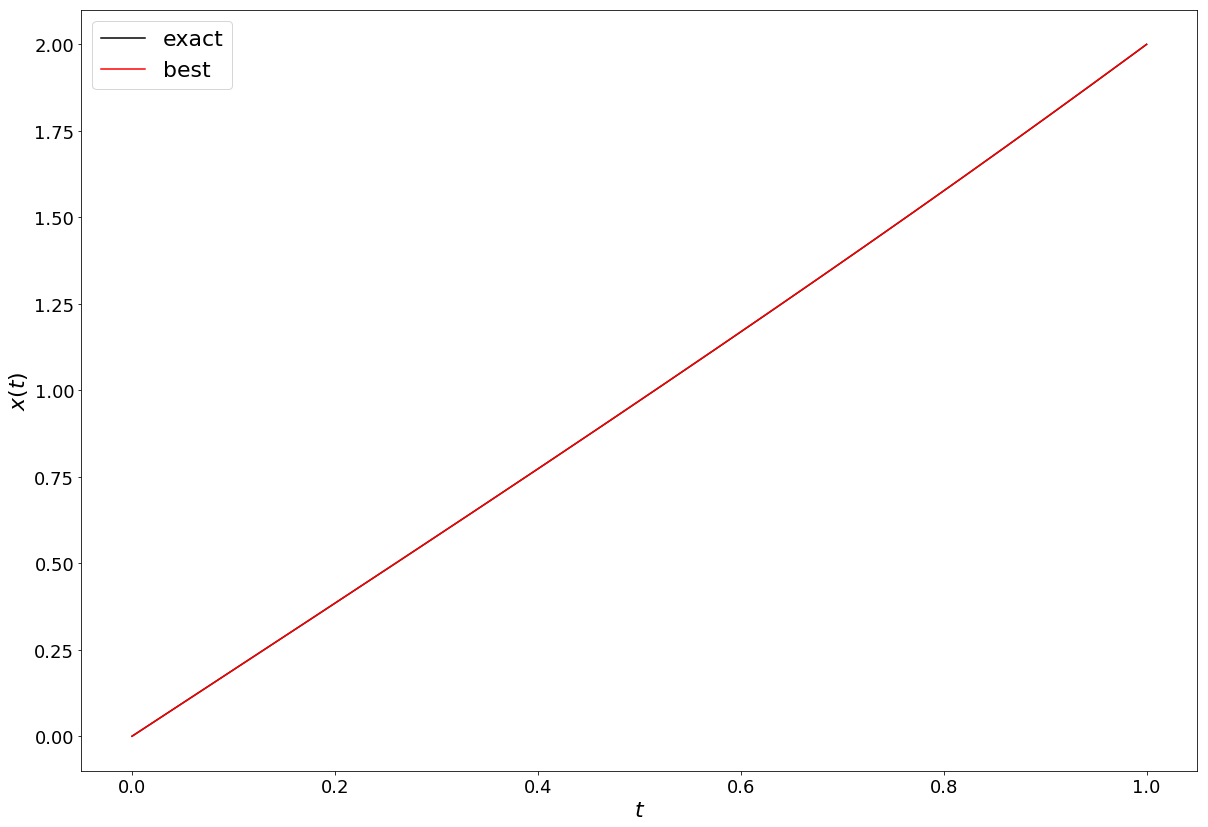

In [84]:
i = 0

ts = np.linspace(nns[i][0][0].t_0, nns[i][0][0].t_f, nns[i][1][0]+1)

plt.figure(figsize=(20,14))

plt.plot(ts, nns[i][0][0].x_exact(ts), color='black', label='exact')
plt.plot(ts, nns[i][3][3], color='red', label=nns[i][4])

plt.xticks(fontsize='18')
plt.yticks(fontsize='18')
plt.xlabel('$t$', fontsize=22)
plt.ylabel('$x(t)$', fontsize=22)
plt.legend(fontsize='22')
plt.show()

### 4.2 Comparison of convergences

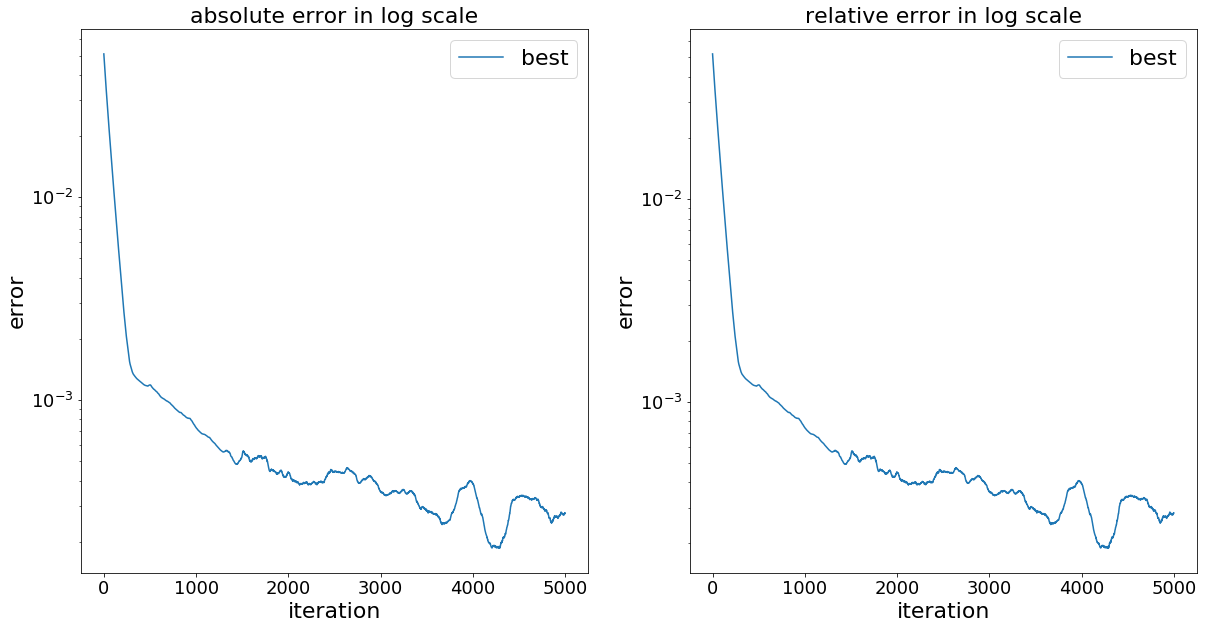

In [91]:
n_skip = 0

fig, ax = plt.subplots(1, 2, figsize=(20,10))

for i in range(len(nns)-1):
    ax[0].plot(range(len(nns[i][3][0]))[n_skip:], nns[i][3][0][n_skip:], label=nns[i][4])

ax[0].tick_params(axis='x', labelsize=18)
ax[0].tick_params(axis='y', labelsize=18)
ax[0].set_xlabel('iteration', fontsize=22)
ax[0].set_ylabel('error', fontsize=22)
ax[0].set_yscale('log')
ax[0].set_title('absolute error in log scale', fontsize=22)
ax[0].legend(fontsize=22)

for i in range(len(nns)-1):
    ax[1].plot(range(len(nns[i][3][1]))[n_skip:], nns[i][3][1][n_skip:], label=nns[i][4])

ax[1].tick_params(axis='x', labelsize=18)
ax[1].tick_params(axis='y', labelsize=18)
ax[1].set_xlabel('iteration', fontsize=22)
ax[1].set_ylabel('error', fontsize=22)
ax[1].set_yscale('log')
ax[1].set_title('relative error in log scale', fontsize=22)
ax[1].legend(fontsize=22)

## 5. Поиск оптимальной модели

### 5.1 Результаты для сетей с одним скрытым слоем

In [62]:
df = pd.read_csv('saves/results1layer.csv', index_col=0)

In [73]:
# grouping by all parameters and averaging relative error by problems and tests

df2 = df.drop(columns=['problem', 'test_number', 'abs_error'])
df2 = df2.groupby(['neurons_1', 'neurons_2', 'neurons_3', 'activation',
                   'learning_rate', 'lambda_2', 'momentum']).mean()
df2 = df2.reset_index()
df2.sort_values('rel_error').head(20)

,neurons_1,neurons_2,neurons_3,activation,learning_rate,lambda_2,momentum,rel_error
244,8,0,0,1,0.006310,0.000,0.01,0.001295
243,8,0,0,1,0.006310,0.000,0.00,0.001478
245,8,0,0,1,0.006310,0.000,0.10,0.001482
248,8,0,0,1,0.006310,0.001,0.10,0.001511
247,8,0,0,1,0.006310,0.001,0.01,0.001601
246,8,0,0,1,0.006310,0.001,0.00,0.001691
251,8,0,0,1,0.006310,0.010,0.10,0.002321
250,8,0,0,1,0.006310,0.010,0.01,0.002556
249,8,0,0,1,0.006310,0.010,0.00,0.002568
92,3,0,0,1,0.025119,0.000,0.10,0.003111


### 5.2 Код для запуска в Google Colab

In [89]:
prob_list = [constrained_problems[1], constrained_problems[2], constrained_problems[3], constrained_problems[4], constrained_problems[5]]
sizes_list = [[3], [8], [20]]
act_list = [(torch.nn.Tanh(), torch.nn.Identity()), (CosineLayer(), torch.nn.Identity()), (PowerLayer(), torch.nn.Identity())]
lr_list = list(np.logspace(-4, -1, 6))
l2_list = [0] + list(np.logspace(-3, -2, 2))
mom_list = [0] + list(np.logspace(-2, -1, 2))

n_tests = 3

In [ ]:
nns = []
res = []

cnt = 0
for i in range(1,1):
    for sizes in sizes_list:
        for j in range(3):
            for lr in lr_list:
                for l2 in l2_list:
                    for mom in mom_list:
                        for k in range(n_tests):
                            res.append([i, sizes[0], j, lr, l2, mom, k, None])
                            nn_params = (prob_list[i], sizes, act_list[j], True)
                            sgd_params = (500, 2000, simpsons_rule, lr, (2500, 0.5), mom, 0, 0, l2, 1e-4, False)
                            sgd_res = (None, None, None, None, None, None)
                            nns.append([nn_params, sgd_params, None, sgd_res, str(cnt)])
                            cnt += 1

In [ ]:
for i in range(len(nns)):
    if i % 10 == 0:
        print(i, 'complete')
    nns[i][2] = CVmodel(nns[i][0][0], nns[i][0][1], nns[i][0][2], fix_first_ones=nns[i][0][3])
    nns[i][3] = nns[i][2].optimize_SGD(*nns[i][1])
    res[i][7] = nns[i][3][2]

np.save('drive/My Drive/project/results2_5.npy', np.array(res))

## 6. Прочее

### 6.1 Обработка `results2_x.npy`

In [50]:
# raw data: (results2_x.npy)
#
# column 0: problem number 1-5 from constrained_problems
# column 1: number of neurons in 1st layer
# column 2: activation layer (1 - tanh, 2 - cosine, 3 - power)
# column 3: learning rate
# column 4: lambda_2
# column 5: momentum
# column 6: test number
# column 7: absolute error

# norms of 1-5 exact solutions
norms = [np.mean(np.abs(constrained_problems[i].x_exact(np.linspace(constrained_problems[i].t_0,
                                                                    constrained_problems[i].t_f,500+1)[:-1])))
         for i in range(1,6)]
print("Exact solutions' norms:")
print(norms)

# loading raw data
raw_res = []
for i in range(5):
    name = 'saves/aux/results2_'+str(i+1)+'.npy'
    raw_res.append(np.load(name))

    # adding relative error and 2nd/3dcolumn
    a = np.zeros((raw_res[i].shape[0], raw_res[i].shape[1]+3))
    a[:,0] = np.full_like(a[:,0], i+1)
    a[:,1] = raw_res[i][:,1]
    a[:,4:-1] = raw_res[i][:,2:]
    a[:,-1] = raw_res[i][:,-1] / norms[i]
    raw_res[i] = a
    
# stacking vertically
res = np.vstack([*raw_res])
print("Resulting shape:", res.shape)

# column 0: problem number 1-5 from constrained_problems
# column 1: number of neurons in 1st layer
# column 2: number of neurons in 2st layer
# column 3: number of neurons in 3st layer
# column 4: activation layer (1 - tanh, 2 - cosine, 3 - power)
# column 5: learning rate
# column 6: lambda_2
# column 7: momentum
# column 8: test number
# column 9: absolute error
# column 10: relative error

# creating a dataframe

df = pd.DataFrame(res)
df.columns = ['problem', 'neurons_1', 'neurons_2', 'neurons_3', 'activation', 'learning_rate', 'lambda_2',
             'momentum', 'test_number', 'abs_error', 'rel_error']

# setting correct data types
for col in ['problem', 'neurons_1', 'neurons_2', 'neurons_3', 'activation', 'test_number']:
    df[col] = df[col].astype(int)
    
df.to_csv('saves/results1layer.csv')

Exact solutions' norms:
[0.4611173112990519, 0.2919894214392691, 2.586760368822707, 0.5835081006270234, 1.0627144175786638]
Resulting shape: (7290, 11)
